# OpSim -- the updated simulation notebook

## About

This notebook is for testing of the OpSim functionality.
Data is read from prefabricated files containing the Sun and the two Satellites' positions as time series. The data is stored and read in the HDF5 format.

In [21]:
# Jupyter magic for autoreload:
%reload_ext autoreload
%autoreload 2

# Standard imports and utility ---
import  os, sys

import  numpy as np
import  yaml
import  matplotlib.pyplot as plt
import  simpy

# ---------------------------------------------------------
import  lusee        # Core lusee software
import  nav          # Astro/observation wrapper classes
from    nav import *
from    utils.timeconv import *

import  sim          # Main simulation handler
from    sim import Simulator

print("---------------------------------- PATH ----------------------------------------")
for path_part in sys.path:
    if path_part!='': print(f'''{path_part}''')



print('--------------------------------- VERSIONS -------------------------------------')
print(f'''simpy: {simpy.__version__}, lusee: {lusee.__version__}, sim: {sim.__version__}''')

---------------------------------- PATH ----------------------------------------
/home/maxim/projects/lusee/opsim/notebooks
/home/maxim/projects/lusee/luseepy
/home/maxim/projects/lusee/opsim
/home/maxim/.virtualenvs/lusee/lib/python3.10/site-packages/backports
/usr/local/lib/python310.zip
/usr/local/lib/python3.10
/usr/local/lib/python3.10/lib-dynload
/home/maxim/.virtualenvs/lusee-simpy/lib/python3.10/site-packages
--------------------------------- VERSIONS -------------------------------------
simpy: 4.0.2, lusee: 1.2-dev, sim: 0.1


In [22]:
orbitals    = "../data/20250204-20250807.hdf5"
modes       = "../config/modes.yml"
devices     = "../config/devices.yml"
comtable    = "../config/comtable-20250204-20250807-new.yml"

In [23]:
initial_time=1548
until=11465

smltr = Simulator(orbitals, modes, devices, comtable, initial_time=initial_time, until=until)

mjd_start   = smltr.sun.mjd[initial_time]
mjd_end     = smltr.sun.mjd[until]

print(f'''Initial time in ticks: {initial_time}, mjd: {mjd_start}, datetime: {mjd2dt(mjd_start)}''')
print(f'''Until time in ticks: {until}, mjd: {mjd_end}, datetime: {mjd2dt(mjd_end)}''')

Shape of the data payload: (17760, 7)
Created a Battery with initial charge: 100.0, capacity: 1200.0
Initial time in ticks: 1548, mjd: 60726.125, datetime: 2025-02-20 03:00:00
Until time in ticks: 11465, mjd: 60829.427083333336, datetime: 2025-06-03 10:15:00


In [15]:
# OPTIONAL
smltr.info()

Orbitals file: ../data/20250204-20250807.hdf5
------------------
Modes file: ../config/modes.yml
science
	spectrometer
		SCIENCE
	comms
		OFF
	bms
		OFF
	controller
		ON
charge
	spectrometer
		OFF
	comms
		OFF
	bms
		ON
	controller
		ON
comms
	spectrometer
		OFF
	comms
		ON
	bms
		ON
	controller
		ON
powersave
	spectrometer
		OFF
	comms
		OFF
	bms
		OFF
	controller
		ON

------------------
Devices file: ../config/devices.yml
------------------
Comtable file: ../config/comtable-20250204-20250807-new.yml
1
	start
		60726.13541667
	mode
		charge
2
	start
		60740.9375
	mode
		powersave
3
	start
		60755.73958333
	mode
		science
4
	start
		60770.45833333
	mode
		powersave

------------------
Day condition at start and end of the simulation: False, False


---

### Optional -- some graphs.

Can scroll down to run the sim


In [ ]:
# OPTIONAL


# Get a handle on the sun and the satellite, in case needed for diagnostics
mySun = smltr.sun
mySat = smltr.esa

print(mySun.N)

fig, (p1, p2) = plt.subplots(1,2)
fig.suptitle('Simulation', fontsize=20)
plt.rcParams["figure.figsize"] = [20., 8.]
plt.rcParams["figure.autolayout"] = True


p1.set_xlabel('Time (MJD)')
p2.set_xlabel('Time (MJD)')

p1.plot(mySat.mjd, mySat.alt,  color="orange", label="Sat Alt")
p1.plot(mySun.mjd, mySun.alt,  color="blue",   label="Sun Alt")

p2.plot(mySat.mjd, mySat.az, color="magenta",label="Sat Az")
p2.plot(mySun.mjd, mySun.az, color="red",    label="Sun Az")


p1.grid(True)
_ = p1.legend()

p2.grid(True)
_ = p2.legend()


In [ ]:
# OPTIONAL

print(f'''Sunrise: {mySun.sunrise}''')

plt.rcParams["figure.figsize"] = [10., 10.]
# plt.rcParams["figure.autolayout"] = True

ax=plt.subplot()

ax.plot(mySun.mjd, smltr.controller.power*100.,  color="red",    label="Panel power*100")
ax.grid(True)


---

### Run the simulation

In [24]:
# smltr.env.process(smltr.run())
smltr.simulate()

---

### Plot the results

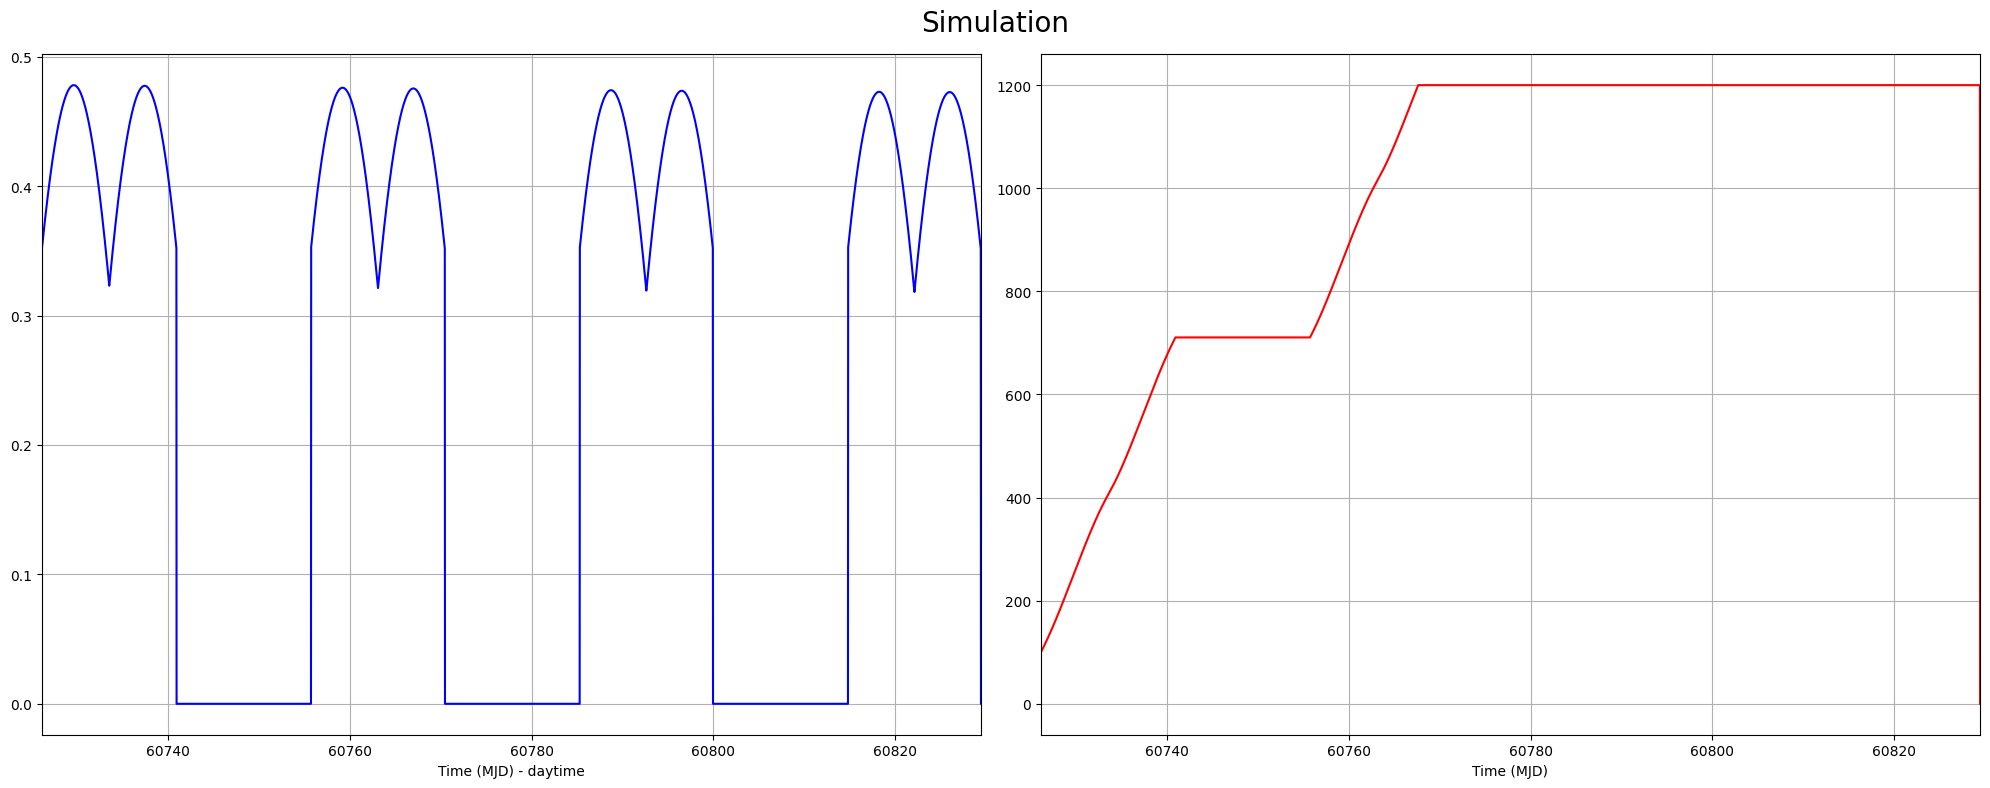

In [25]:
fig, (p1, p2) = plt.subplots(1,2)
fig.suptitle('Simulation', fontsize=20)
plt.rcParams["figure.figsize"] = [20., 8.]
plt.rcParams["figure.autolayout"] = True


p1.set_xlabel('Time (MJD) - daytime')
p2.set_xlabel('Time (MJD)')


mjd = smltr.sun.mjd
p1.plot(mjd, smltr.controller.power,  color="blue",   label="Panel exposure (area units)")
p2.plot(mjd, smltr.monitor.battery, color="red",    label="Panel power (a.u.)")


xlo = mjd[smltr.initial_time]
xhi = mjd[smltr.until]

p1.set_xlim([xlo, xhi])
p2.set_xlim([xlo, xhi])

p1.grid(True)
p2.grid(True)

plt.show()






---

## Archived utilities

Useful bits of code that aren't necesserily executed every time.


In [ ]:
# Pretty print the dictionary we read from the input YAML, for an extra check:
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))

In [ ]:
print('Current directory:', os.getcwd())

# Define files to configure the run:

conf_flnm   = '../config/conf.yml'
modes_flnm  = '../config/modes.yml'
devices_flnm= '../config/devices.yml'


print(f'''-------------------- {conf_flnm} ---------------------------------------------------''')
conf    = yaml.safe_load(open(conf_flnm, 'r'))
pretty(conf)


print(f'''-------------------- {modes_flnm} ---------------------------------------------------''')
modes   = yaml.safe_load(open(modes_flnm, 'r'))
pretty(modes)


print(f'''-------------------- {devices_flnm} ---------------------------------------------------''')
devices   = yaml.safe_load(open(modes_flnm, 'r'))
pretty(devices)
